Import necessary packages: Numpy, Pandas, matplotlib

Tim von Känel und Tim Birkner

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Mount your google drive (if you have a google account) or upload files (go on the file icon on the left -> right click). Copy path of zip.train and zip.test and load them as numpy arrays using the following code (insert the path as string).

In [2]:
path_to_train = 'zip.train'
path_to_test = 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. Note the only difference is
# that we don't load as many ones as we load zeros.

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1][:30]
X_train = np.vstack((X_train_0, X_train_1))

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1][:30]
y_train = np.hstack((y_train_0, y_train_1))

X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1][:12]
X_test = np.vstack((X_test_0, X_test_1))

y_test_0 = y_test[y_test == 0]
y_test_1 = y_test[y_test == 1][:12]
y_test = np.hstack((y_test_0, y_test_1))
print(y_test.shape)

(371,)


In [3]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 1-sample_digits[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')


In [4]:
def accuracy(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Invalid shapes received, y_trues shape is {y_true.shape} while y_pres shape is {y_pred.shape}.")
    return (1 / y_true.shape[0]) * np.sum(y_true == y_pred)


class KNearestNeighbors():
    '''
    Think about defining more functions that will help you building this algorithm.
    Optimally, one that takes in k and a test image as a parameter.
    '''
    def __init__(self, k, num_classes):
        self.k = k
        self.num_classes = num_classes
        
    def fit(self, x, y):
        self.x = x
        self.y = y
    
    def squared_euclidean_distance(self, x_1, x_2):
      '''
      np.sum(x, axis = 1) will be summing all elements over the pixel dimension (axis = 1)
      '''
      return np.sum((x_1-x_2)**2, axis = 0)
    
    def predict(self, x):
        predictions = []
        for it, pred_row in enumerate(x):
            knn = []
            for train_x, train_y in zip(self.x, self.y):
                dist = self.squared_euclidean_distance(pred_row, train_x)
                if len(knn) >= self.k and dist > knn[-1][0]:
                    continue

                hasInserted = False
                for i in range(len(knn)):
                    if knn[i][0] > dist:
                        knn.insert(i, (dist, train_y))
                        hasInserted = True
                        break

                if not hasInserted and len(knn) < self.k:
                    knn.append((dist, train_y))

                if len(knn) > self.k:
                    knn.pop()
                    
            classes = [0 for i in range(self.num_classes)]
            for neighbour in knn:
                classes[int(neighbour[1])] += 1
                
            predictions.append(np.argmax(classes))
            
        return np.array(predictions)

(90,)


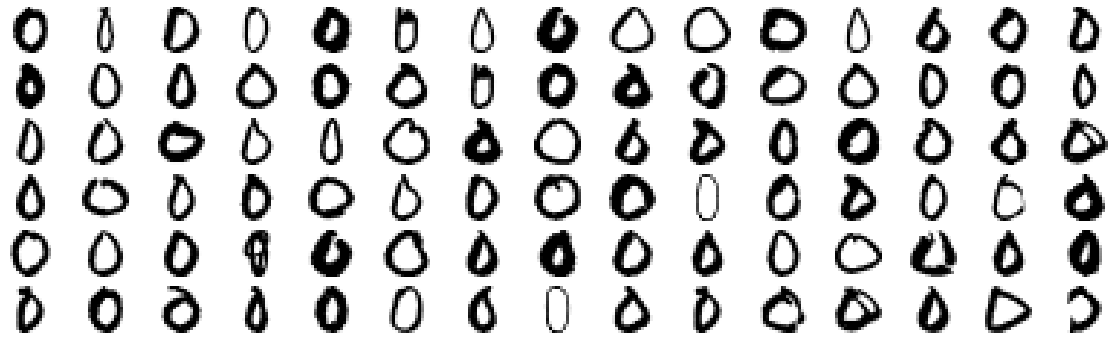

In [5]:
show_numbers(X_test)

Choose one of the classifiers you implemented and use it on the following task: Take a look at the provided notebook. It loads the ZIP-Code’s zeros and ones, but now there are manymore zeros than there are ones. We are going to believe that these digits represent geneticdata. Actually, we are virologists trying to develop a test to determine which of the data belongs to infected patients (the ones) and which do not (the zeros). Train/apply your model on the data and do the tasks of the exercise.

In [6]:
def k_fold(k, x, y):
    perm = np.random.permutation(x.shape[0])
    index_groups = []
    for i in range(k):
        fr = i * (x.shape[0] // k)
        until = (i + 1) * (x.shape[0] // k)
        index_groups.append(perm[fr:until])
    
    k_folds = []
    for i in range(k):
        training_idz = []
        for j in range(k):
            if i == j:
                validation_idz = index_groups[j]
            else:
                training_idz = training_idz + list(index_groups[j])
        k_folds.append(((x[training_idz], y[training_idz]), (x[validation_idz], y[validation_idz])))

    return k_folds

def confusion_matrix(y_true, y_hat):
    """
    y_true = 1, y_hat = 1 => tp
    y_true = 1, y_hat = 0 => fn
    y_true = 0, y_hat = 1 => fp
    y_true = 0, y_hat = 0 => tn
    """
    conf_mat = np.zeros((2, 2))
    for y_t, y_h in zip(y_true, y_hat):
        if y_t == 1 and y_h == 1:
            conf_mat[0, 0] += 1
        elif y_t == 1 and y_h == 0:
            conf_mat[1, 0] += 1
        elif y_t == 0 and y_h == 1:
            conf_mat[0, 1] += 1
        else:
            conf_mat[1, 1] += 1
    return conf_mat

Use a 5-fold Cross-Validation to evaluate your model and optimize hyperparameters (e.g.
the threshold in Logistic Regression or k in K-NNs). Print the mean and variance of your
validation. What do both values tell you about your model?

In [7]:
folds = k_fold(5, X_test, y_test)

for k in range(8, 18, 2):
    avg_train_acc = avg_test_acc = 0
    conf_matrix = np.zeros((2, 2))
    for fold in folds:
        model = KNearestNeighbors(k=k, num_classes=2)
        x_train, y_train = fold[0]
        x_val, y_val = fold[1]
        model.fit(x_train, y_train)
        y_hat_val = model.predict(x_val)
        y_hat_train = model.predict(x_train)
        avg_test_acc += accuracy(y_val, y_hat_val) / 5
        avg_train_acc += accuracy(y_train, y_hat_train) / 5
        
    mean_acc = ((avg_test_acc + avg_train_acc) / 2)
    var_acc = (avg_test_acc - mean_acc) ** 2
    print(f"For k={k} the model has an avg validation accuracy of {round(avg_test_acc, 4)} and an avg training accuracy of {round(avg_train_acc, 4)}")
    print(f"For k={k} the model has a variance of {var_acc}")

For k=8 the model has an avg validation accuracy of 0.9973 and an avg training accuracy of 1.0
For k=8 the model has a variance of 1.8261504747990861e-06
For k=10 the model has an avg validation accuracy of 0.9973 and an avg training accuracy of 1.0
For k=10 the model has a variance of 1.8261504747990861e-06
For k=12 the model has an avg validation accuracy of 0.9973 and an avg training accuracy of 1.0
For k=12 the model has a variance of 1.8261504747990861e-06
For k=14 the model has an avg validation accuracy of 0.9973 and an avg training accuracy of 1.0
For k=14 the model has a variance of 1.8261504747990861e-06
For k=16 the model has an avg validation accuracy of 0.9865 and an avg training accuracy of 0.9946
For k=16 the model has a variance of 1.6435354273192675e-05


k = 10 ist ein guter hyperparameter, da dieser eine durchschnittliche validierungsgenauigkeit von 0.9973% hat. Diese Genauigkeit ist sehr hoch. Gründe hierfür könnte es sein, dass es tatsächlich sehr einfach ist für KNN nullen von Einsen zu unterscheiden, oder aber auch dass sich die validierungsklassen und trainingsklassen von unserem k-fold überlappen. Dies konnten wir jedoch auch nacht tests nicht feststellen.
Insgesamt ist die avg validation accuracy sowie die avg training accuracy hoch, was heißt dass das Modell nicht underfitted und somit keinen hohen bias hat.
Die Varianz ist relativ gering, was heißt dass das modell gut generalisiert und somit nicht overfittet.

In [9]:
model = KNearestNeighbors(k=10, num_classes=2)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_hat)
recall = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1] + 10 ** -20)
precision = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0] + 10 ** -20)
f1_score = (2 * precision * recall) / (precision + recall + 10 ** -20)
print("Confusion matrix")
print(conf_matrix)
print()
print(f"The model has a recall of {round(recall, 4)}, a precision of {round(precision, 4)} and a f1 score of {round(f1_score, 4)}")

Confusion matrix
[[  0.   0.]
 [ 12. 359.]]

The model has a recall of 0.0, a precision of 0.0 and a f1 score of 0.0


In [14]:
baseline = np.zeros_like(y_hat)
conf_matrix = confusion_matrix(y_test, baseline)
recall = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1] + 10 ** -20)
precision = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0] + 10 ** -20)
f1_score = (2 * precision * recall) / (precision + recall + 10 ** -20)

In [15]:
print("Confusion matrix")
print(conf_matrix)
print()
print(f"The model has a recall of {round(recall, 4)}, a precision of {round(precision, 4)} and a f1 score of {round(f1_score, 4)}")

Confusion matrix
[[  0.   0.]
 [ 12. 359.]]

The model has a recall of 0.0, a precision of 0.0 and a f1 score of 0.0


Unser modell funktioniert genauso schlecht wie die baseline, was bedeutet dass das Modell trotz hoher Genauigkeit nicht in der Lage ist Einsen richtig zu predicten.

If your test is positive, what is the probability for a patient to be actually positive.
Would you recommend using the test you developed? Describe what the problem is if
there is one.

Die geforderte Metrik ist die precision und diese ist in unserem Fall 0%. Den Test den wir entwickelt haben würden wir nicht empfehlen. Die Genauigkeit ist zwas sehr hoch, das Problem ist jedoch dass beim Virustesten es wichtiger ist die false negatives gering zu halten als die false positives. Wenn bei einem ein Virus erkannt wird, obwohl man keines hat.